In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import desc


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#inspect tables and get columns

inspector = inspect(engine)
inspector.get_table_names()

#columns = inspector.get_columns('Measurement')
#for c in columns:
#    print(c['name'], c["type"])
    
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
#Query tables to see example data

#engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

readings_last_12mo=[]
current_time = dt.date.today()
date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

print(date[0])

year_ago = dt.datetime.strptime(date[0], "%Y-%m-%d") - dt.timedelta(days=366)

sel=[Measurement.date, Measurement.prcp]
readings_last_12mo = session.query(*sel).\
    filter(Measurement.date >= year_ago).all()
#print(readings_last_12mo)



2017-08-23


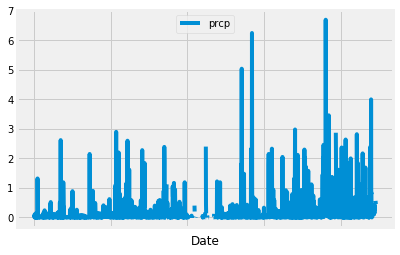

In [14]:
precip_df = pd.DataFrame(readings_last_12mo, columns=['date', 'prcp'])
precip_df.set_index('date', inplace=True)

precip_df.plot(use_index = True)
plt.xlabel('Date')
plt.legend(loc='upper center')
plt.savefig("PrecipitationAnalysis.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df['prcp'].describe()



count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
q = (session.query(Measurement.station, func.count(Measurement.id).label("# stations"))
    .group_by(Measurement.station).\
     order_by(desc(func.count(Measurement.id)))
     ).all()
q


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sta_averages = []
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)] 

sta_averages = session.query(*sel).\
     filter(Measurement.station == q[0][0]).all()
sta_averages



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

C:\Users\summe\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


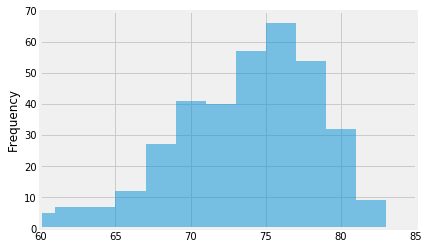

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

readings_last_12mo2=[]
current_time = dt.date.today()
date = session.query(Measurement.date).\
    filter(Measurement.station == q[0][0]).\
    order_by(Measurement.date.desc()).first()

#print(date[0])

year_ago = dt.datetime.strptime(date[0], "%Y-%m-%d") - dt.timedelta(days=366)

sel=[Measurement.date, Measurement.tobs]
readings_last_12mo2 = session.query(*sel).\
    filter(Measurement.station == q[0][0]).\
    filter(Measurement.date >= year_ago).all()
#print(readings_last_12mo)
num_bins = 12
temp_df = pd.DataFrame(readings_last_12mo2, columns=['date', 'tobs'])
temp_df.set_index('date', inplace=True)
numpy_data = temp_df.as_matrix()


plt.hist(numpy_data, num_bins, alpha=0.5)
plt.axis([60,85,0,70]) 
plt.ylabel('Frequency')
plt.savefig("TempHistogram.png")
plt.show()



In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temp1=calc_temps('2016-08-23', '2017-08-23')
print(calc_temp1)


[(58.0, 74.59058295964125, 87.0)]


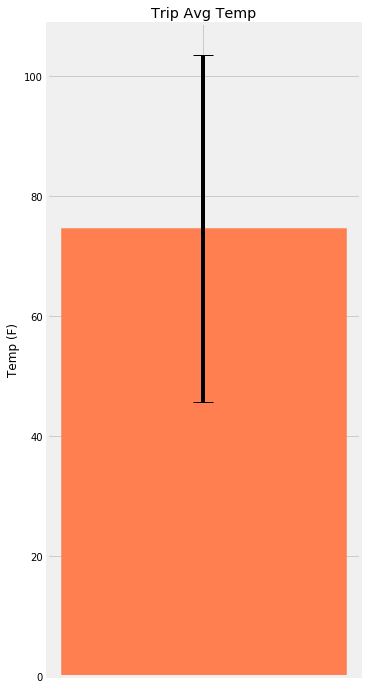

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_df = pd.DataFrame(calc_temp1, columns=['min', 'avg', 'max'])
temp_df.head()
temp_min = list(temp_df['min'])
temp_avg = list(temp_df['avg'])
temp_max = list(temp_df['max'])
t_peak = list(temp_df['max'] - temp_df['min'])

# Build the plot
plt.figure(figsize=(5,12))
barlist=plt.bar([''],temp_avg,yerr=t_peak, capsize=10)
#plt.axis([0,0,0,100])
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')

#plt.tight_layout()
barlist[0].set_color('coral')
plt.savefig('MinAvgMaxBar.png')
plt.show()



In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


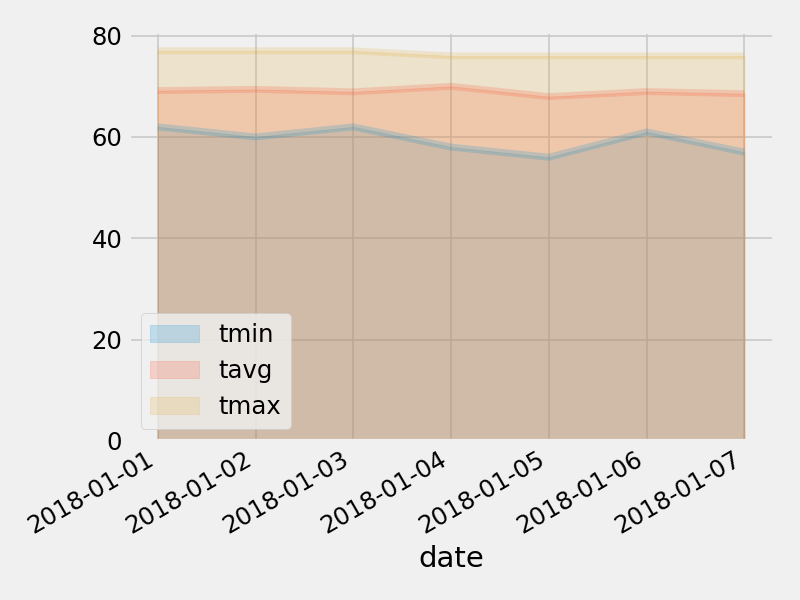

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
